# Setup

**Imports**

In [ ]:
!pip install loadmydata tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 3.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

**Utility functions**

In [ ]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

Modified plotting function

In [ ]:
def plot_avg_with_std(x, y, title=None, xlabel=None, ylabel=None):
  fig, ax = fig_ax(figsize=(9, 5))

  avg = y.mean(axis=0)
  std = y.std(axis=0)
  ax.plot(x, avg, 'k-', label='mean')
  ax.fill_between(x, avg-std, avg+std, alpha=0.5, label='standard deviation')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.show()

First subquestion: sample autocovariances

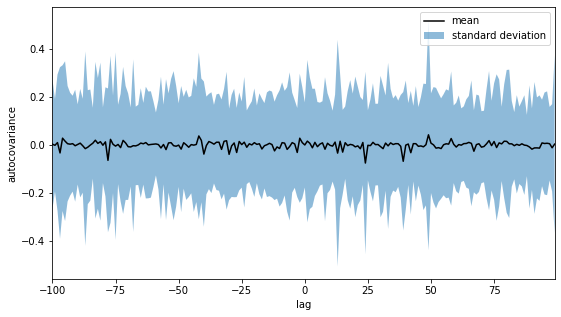

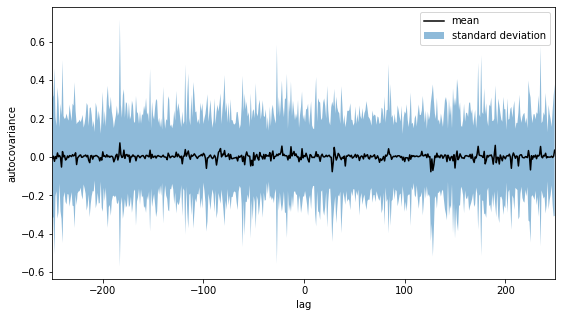

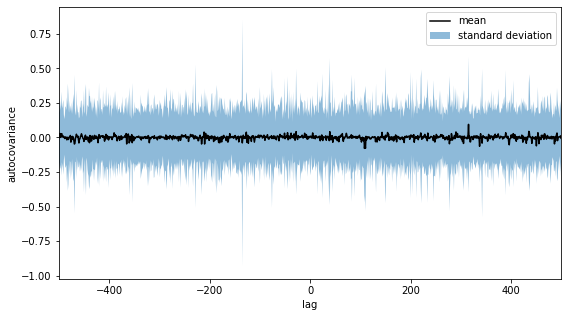

In [ ]:
from statsmodels.tsa.stattools import acovf
# This is an example of plot (random data). You can change it if you want.

## Change the following lines
Ns = [200, 500, 1000]
n_simulations = 100


for N in Ns:
    samples = np.random.randn(n_simulations, N)
    lags = list(range(-N//2, N//2))
    autocovariances = np.apply_along_axis(acovf, 0, samples, adjusted=True, fft=False)
    plot_avg_with_std(lags, autocovariances,
                    xlabel='lag',
                    ylabel='autocovariance'
                    )
##

Second subquestion: periodograms

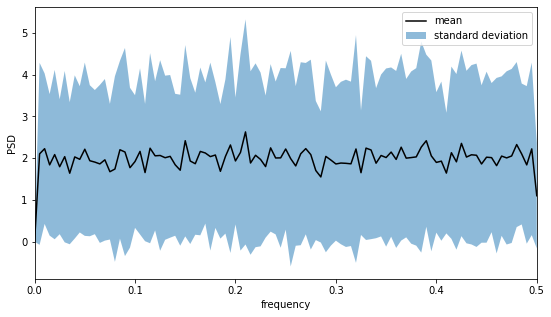

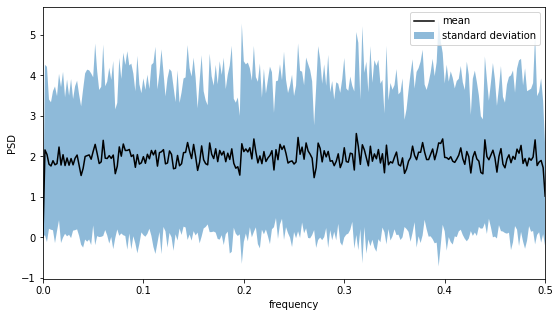

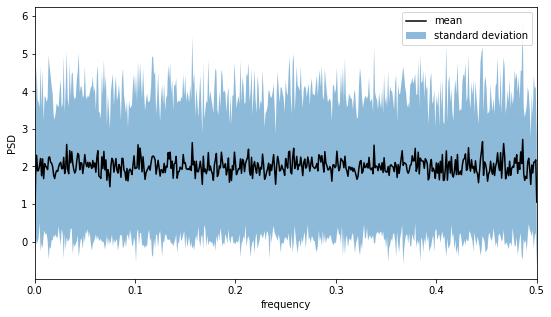

In [ ]:
from scipy.signal import periodogram

for N in Ns:
    signals = np.random.randn(n_simulations, N)
    freqs, periodograms = periodogram(signals, fs=1) 
    plot_avg_with_std(freqs, periodograms, xlabel='frequency', ylabel='PSD')

## Question 9

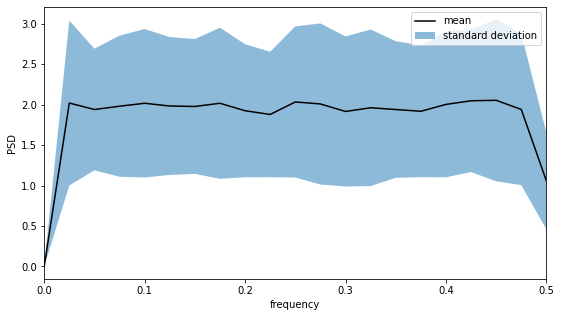

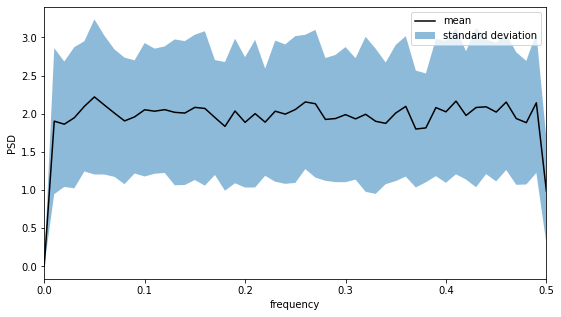

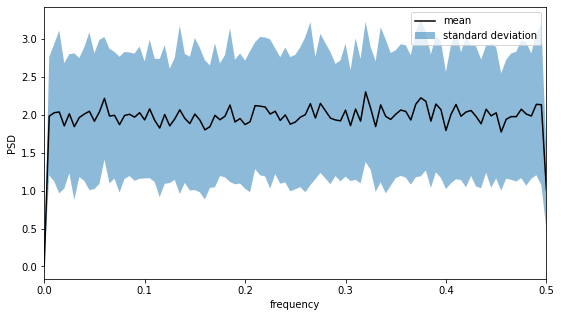

In [ ]:
from scipy.signal import periodogram

K = 5

for N in Ns:
    signals = np.random.randn(n_simulations, N)
    section_length = N // K
    sections = [
      signals[:,i*section_length:(i+1)*section_length]
      for i in range(K)
    ]
    sections = np.stack(sections, axis=2)
    freqs, periodograms = periodogram(sections, fs=1, axis=1) 
    bartlett_estimates = periodograms.mean(axis=-1)
    plot_avg_with_std(freqs, bartlett_estimates, xlabel='frequency', ylabel='PSD')

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [ ]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

100%|██████████| 202M/202M [05:28<00:00, 614kiB/s]


## Question 10

We first process the time series data through the tslearn library to allow processing time series of different lengths in the kNN classifier.

In [ ]:
from tslearn.utils import to_time_series_dataset

X_train = to_time_series_dataset(X_train)
X_test = to_time_series_dataset(X_test)

Hyperparameter search for the best k value for KNN

In [ ]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': list(range(2, 50))
}

clf = GridSearchCV(
      KNeighborsTimeSeriesClassifier(metric='dtw', n_jobs=-1),
      param_grid,
      scoring='f1',
      n_jobs=-1,
      cv=5,
      verbose=10
    )

clf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=KNeighborsTimeSeriesClassifier(n_jobs=-1),
             n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, ...]},
             scoring='f1', verbose=10)

In [ ]:
optimal_k = clf.best_estimator_.n_neighbors
print("Best number of neighbors: ", optimal_k)

Best number of neighbors:  5


In [ ]:
best_score = clf.best_score_
print("Validation f1 score: ", best_score)

Validation f1 score:  0.781814185073362


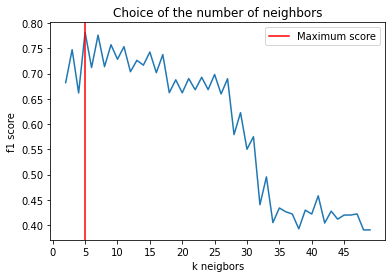

In [ ]:
import matplotlib.pyplot as plt

scores = clf.cv_results_['mean_test_score']
k_values = [param['n_neighbors'] for param in clf.cv_results_['params']]

plt.plot(k_values, scores)
plt.xlabel('k neigbors')
plt.ylabel('f1 score')
plt.xticks(np.arange(0, 50, 5))
plt.title('Choice of the number of neighbors')
plt.axvline(k_values[np.argmax(scores)], color='red', label='Maximum score')
plt.legend()
plt.show()

Caluclating the test f1 score

In [ ]:
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay

pred_test = clf.predict(X_test)
f1_score(y_test, pred_test)

0.5132743362831859

Full metrics

In [ ]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.08      0.27      0.13        15
           1       0.72      0.40      0.51        73

    accuracy                           0.38        88
   macro avg       0.40      0.33      0.32        88
weighted avg       0.62      0.38      0.45        88



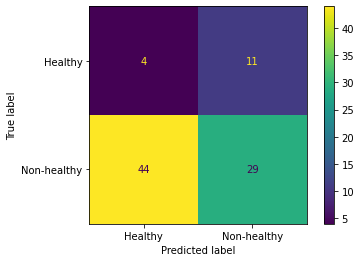

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_test, display_labels=['Healthy', 'Non-healthy'])
plt.show()

## Question 11

Badly classified healthy step

Index 33


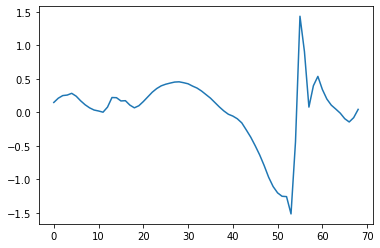

In [ ]:
index = np.logical_and(np.array(y_test) == 0, np.array(pred_test) == 1).argmax()
print(f"Index {index}")
_ = plt.plot(X_test[index])

Badly classified non-healthy step

Index 0


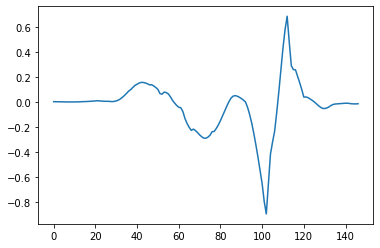

In [ ]:
index = np.logical_and(np.array(y_test) == 1, np.array(pred_test) == 0).argmax()
print(f"Index {index}")
_ = plt.plot(X_test[index])

## Extra 

Plotting the healthy steps

In [ ]:
healthy = np.array(y_test) == 0
X_test_healthy = X_test[healthy]
print(len(X_test_healthy))

15


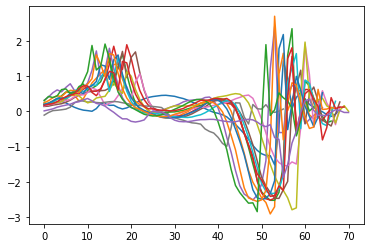

In [ ]:
for x in X_test_healthy:
    plt.plot(x)

Plotting the non-healthy steps

In [ ]:
non_healthy = np.array(y_test) == 1
X_test_non_healthy = X_test[non_healthy]
print(len(X_test_non_healthy))

73


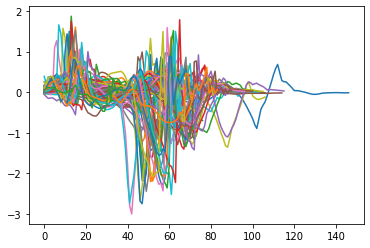

In [ ]:
for x in X_test_non_healthy:
    plt.plot(x)

There is a lot of variability in the non-healthy class.